# Ethan's EDA :)

Start with imports and defining a lambda function to parse dates using inbuild python stuff

* function is made to convert from the date column from string to datetime64 type, and uses the specific layout of Dien's scrape

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from datetime import datetime
dateparse = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S %z %Z")

Read CSV and use datetime function defined above to parse dates as they're read

*not worth taking 7 years to have each cell operating on 4 million comments each, better to just sample a certain amount at random for now*

In [2]:
reviews = pd.read_csv("scraped_comments.csv", parse_dates=['date'], date_parser=dateparse).sample(n=500000, random_state=1)
# ensure that dates are parsed as they are read in using dateparse inline function
# sample 500000 random comments (4 million is too large lol)

Drop unnecessary rows

* accidental repeat scrapes
* empty comments
* comments containing just `No Comments`

Additionally, any comment with 5 words or less is unlikely to be helpful, so drop those too

In [3]:
# drop comments that were accidentally scraped multiple times
reviews.drop_duplicates(subset="comment_id", keep="first", inplace=True)

reviews.dropna(subset=["comment"], inplace=True)
# drop rows containing only "No Comments" (default value assigned by RMP to a review that didn't enter a comment)
reviews = reviews[reviews["comment"] != "No Comments"]
# replace all comments with less than 5 words with a NaN
reviews["comment"] = reviews["comment"].apply(lambda x: x if len(x.split()) > 5 else None)
# drop rows containing NaN comment
reviews.dropna(subset=["comment"], inplace=True)

reviews.shape

(450454, 16)

Keep only desired columns to reduce size of dataframe being whipped around, better for convenience in reading and memory efficiency

Create new column (sentiment) and assign values based on the rating that particular student gave the professor

In [4]:
reviews = reviews.loc[:, ["firstName", "lastName", "comment", "date", "clarityRating"]]        # keep only desired columns
reviews["sentiment"] = 1        # create new sentiment column
reviews["sentiment"] = reviews["clarityRating"].apply(lambda x: 1 if x > 2.5 else 0)        # assign tentative value to sentiment using clarityRating column (star given by student)
reviews.head()

,firstName,lastName,comment,date,clarityRating,sentiment
1218428,Keith,Halladay,Keith is the best. Not afraid to give his hone...,2019-02-07 01:36:03+00:00,5,1
2299033,Charles,Lankau,Lankau was great for 4000 and 5110. He makes c...,2005-06-27 17:47:04+00:00,4,1
2332617,James,McGivern,I hated every second of my life that I had to ...,2009-05-05 12:36:34+00:00,2,0
2300099,Howard G.,Tucker,Crazy Man. No grading system. You dont know yo...,2004-12-17 13:50:08+00:00,5,1
2770766,Paul,Cohen,This teacher is the worst I've ever taken in m...,2014-04-27 19:03:15+00:00,1,0


In [5]:
reviews.reset_index(drop=True, inplace=True)            # reset index, necessary after sampling from csv and dropping rows

In [6]:
# this cell was literally running for 5 hours (on 4 million comments) and didn't finish
# gonna try to find an alternative way to lemmatize and remove stopwords

"""
lemm = WordNetLemmatizer()
for i in range(len(reviews.index)):
    #review = re.sub("[^a-zA-Z]", " ", reviews["comment"][i])
    review = reviews["comment"][i]
    review = review.lower()
    review = review.split()
    review = [lemm.lemmatize(word) for word in review if word not in stopwords.words("english")]
    review = " ".join(review)
    reviews["comment"][i] = review

reviews.head()
"""

'\nlemm = WordNetLemmatizer()\nfor i in range(len(reviews.index)):\n    #review = re.sub("[^a-zA-Z]", " ", reviews["comment"][i])\n    review = reviews["comment"][i]\n    review = review.lower()\n    review = review.split()\n    review = [lemm.lemmatize(word) for word in review if word not in stopwords.words("english")]\n    review = " ".join(review)\n    reviews["comment"][i] = review\n\nreviews.head()\n'

Use spaCy to remove stopwords and place into new list

**IMPORTANT:** *this code does not lemmatize, may explain why it's so much faster than the alternative I've explored so far*

In [7]:
# code from https://www.analyticsvidhya.com/blog/2019/08/how-to-remove-stopwords-text-normalization-nltk-spacy-gensim-python/

from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

nlp = English()
no_stop_words = []

for i in range(reviews.shape[0]):
    text = reviews["comment"][i]
    doc = nlp(text)

    token_list = []
    for token in doc:
        token_list.append(token.text)         # lemmatize

    filtered_sentence = []
    for word in token_list:
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:             # remove stopwords
            filtered_sentence.append(word)
    
    no_stop_words.append(" ".join(filtered_sentence))

Use regex to remove any characters that aren't letters

In [8]:
# removing non-alphabetic characters (may want to keep numbers, will deal with that later)
comments_proper = []

for i in range(reviews.shape[0]):
    review = no_stop_words[i]
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = re.sub('\s+', ' ', review)             # get rid of excess whitespace generated by spaCy's less-than-ideal tokenization
    review = review.lower()                         # lowercase review for uniformity
    comments_proper.append(review)

comments = pd.Series(comments_proper, copy=False)
comments

0         keith best afraid honest opinion grading paper...
1         lankau great makes class fun hilarious prepare...
2         hated second life sit class intelligent man id...
3         crazy man grading system nt know grade tell st...
4         teacher worst taken entire schooling career ru...
                                ...                        
450449    sound angry face right worth wants work hard f...
450450    enthusiastic class talk classes ll set recomme...
450451    best professor taken knowledgeable helpful lik...
450452    guy awful follow syllabus incredibly disorgani...
450453    dr coles nice class easy learn talks entire ti...
Length: 450454, dtype: object

# Plotting most frequent words

Want to figure out which words are most common in our sample, write a function to that effect

*this first plot* <mark>does not</mark> *use the improved Series created immediately above, with stopwords and extraneous characters removed*

As a result, it's quite uninteresting tbh, but it does show why removing stopwords and lowercasing is quite important when dealing with raw data such as this

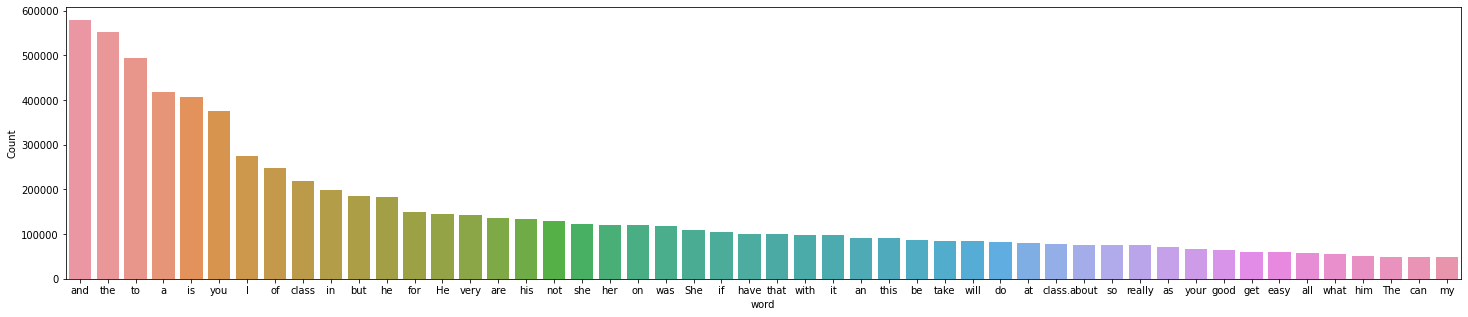

In [9]:
from nltk import FreqDist

%matplotlib inline
def freq_words(x, terms=30):        # function to plot most frequent words
    all_words = " ".join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({"word":list(fdist.keys()), "count":list(fdist.values())})

    d = words_df.nlargest(columns="count", n=terms)
    plt.figure(figsize=(25,5))
    ax = sns.barplot(data=d, x="word", y="count")
    ax.set(ylabel="Count")
    plt.show()

freq_words(reviews["comment"], terms=50)
# IMPORTANT: not interesting when stopwords haven't been removed

Now do it with the better, (slightly) cleaned comments and notice the immediately more meaningful results

**Note:** at the end there, you can see `nt` and `quot`, obviously not real words.

* `nt` appears because of spaCy's tokenization process, which (apparently) splits at apostrophes, and its stopword corpus not accounting for this (the way NLTK does)
* `quot` appears because of RMP's weird HTML encoding process, where some things are not encoded (like periods, exclamation marks, and apostrophes) but some things are (like quotation marks), so the encoded sequence remains in the comment even after removing extraneous characters and such

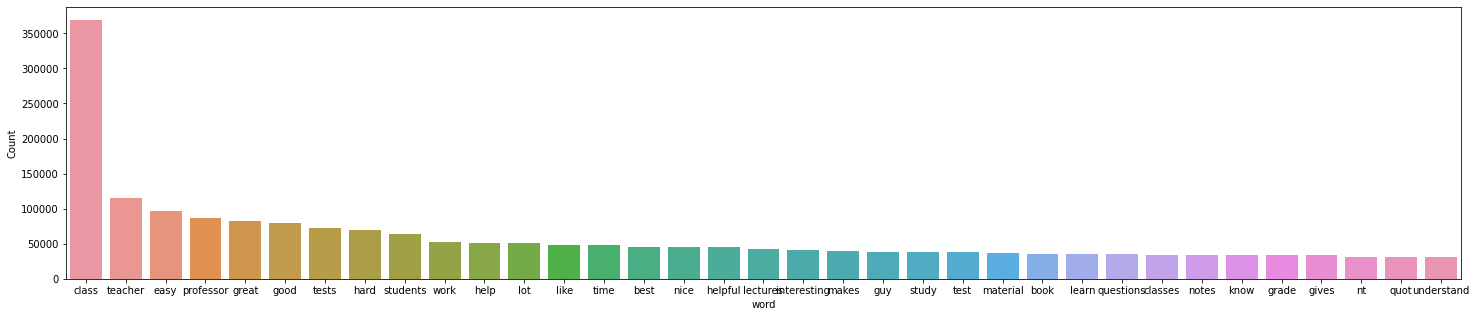

In [10]:
freq_words(comments, terms=35)
# with stopwords being removed, it becomes a bit more interesting
# worth noting that towards the bottom end of the 35 terms appear the words "nt" and "quot", 
    # which appear as a result of spaCy's tokenization splitting apostrophes and HTML encoding, respectively

# Examining dates and distributions thereof

When were these comments made, and do any interesting trends in dates present themselves?

In [11]:
reviews["date"]         # date column is actually of datetime64 type rather than just a string :)

0        2019-02-07 01:36:03+00:00
1        2005-06-27 17:47:04+00:00
2        2009-05-05 12:36:34+00:00
3        2004-12-17 13:50:08+00:00
4        2014-04-27 19:03:15+00:00
                    ...           
450449   2005-12-03 23:57:13+00:00
450450   2005-04-27 21:28:30+00:00
450451   2017-07-25 19:07:19+00:00
450452   2009-12-30 14:23:52+00:00
450453   2018-12-13 16:31:47+00:00
Name: date, Length: 450454, dtype: datetime64[ns, UTC]

Isolate years of dates and notice its value_counts

In [25]:
comment_years = reviews["date"].dt.year
comment_years.value_counts()

2005    62065
2006    43745
2004    38275
2007    36297
2008    35742
2009    33965
2010    32239
2011    28264
2003    21722
2012    20884
2013    18787
2014    17060
2015    15085
2016    13545
2017    10154
2018     8194
2019     5497
2002     4209
2020     2815
2022     1080
2001      686
2000       95
1999       49
Name: date, dtype: int64

Graph years in which comments were made

*skews earlier due to scraping occuring in legacy ID order, so we'll have to scrape more to get a more modern graph*

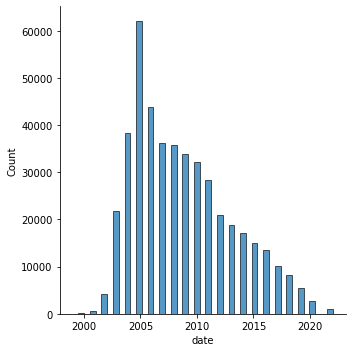

In [13]:
sns.displot(comment_years, kde=False, bins=45)          # number of comments per year
# IMPORTANT: skewed bc of legacy id going from oldest to newest (roughly) and we haven't scraped that many overall

Repeat same as above with months, though graph is less interesting

In [14]:
comment_months = reviews["date"].dt.month

To be fair, you can see that most comments are made in December and May, which is when semesters end.

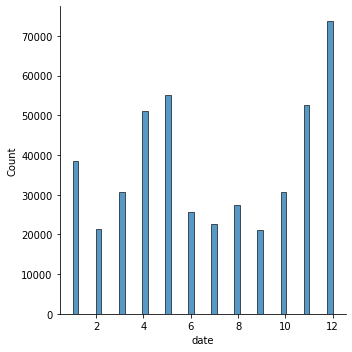

In [15]:
#sns.displot(x=comment_years, y=comment_months, kind="kde", rug=True)   # ignore this lol, just a weird density plot that seems entirely nonsensical
sns.displot(comment_months, kde=False, bins=45)         # plot comment frequency by month
# wouldn't expect this to change too drastically even when scraping more, as trend should be pretty stable

# Determine average number of words per comment

start by making a new column in dataframe containing each word within the comment

In [16]:
reviews["words"] = ""
reviews["words"] = reviews["comment"].apply(lambda x: x.split())
reviews.head()

,firstName,lastName,comment,date,clarityRating,sentiment,words
0,Keith,Halladay,Keith is the best. Not afraid to give his hone...,2019-02-07 01:36:03+00:00,5,1,"[Keith, is, the, best., Not, afraid, to, give,..."
1,Charles,Lankau,Lankau was great for 4000 and 5110. He makes c...,2005-06-27 17:47:04+00:00,4,1,"[Lankau, was, great, for, 4000, and, 5110., He..."
2,James,McGivern,I hated every second of my life that I had to ...,2009-05-05 12:36:34+00:00,2,0,"[I, hated, every, second, of, my, life, that, ..."
3,Howard G.,Tucker,Crazy Man. No grading system. You dont know yo...,2004-12-17 13:50:08+00:00,5,1,"[Crazy, Man., No, grading, system., You, dont,..."
4,Paul,Cohen,This teacher is the worst I've ever taken in m...,2014-04-27 19:03:15+00:00,1,0,"[This, teacher, is, the, worst, I've, ever, ta..."


Make another column counting the words in that comment

In [17]:
reviews["wordCount"] = 0
reviews["wordCount"] = reviews["words"].apply(lambda x: len(x))
reviews.head()

,firstName,lastName,comment,date,clarityRating,sentiment,words,wordCount
0,Keith,Halladay,Keith is the best. Not afraid to give his hone...,2019-02-07 01:36:03+00:00,5,1,"[Keith, is, the, best., Not, afraid, to, give,...",32
1,Charles,Lankau,Lankau was great for 4000 and 5110. He makes c...,2005-06-27 17:47:04+00:00,4,1,"[Lankau, was, great, for, 4000, and, 5110., He...",54
2,James,McGivern,I hated every second of my life that I had to ...,2009-05-05 12:36:34+00:00,2,0,"[I, hated, every, second, of, my, life, that, ...",28
3,Howard G.,Tucker,Crazy Man. No grading system. You dont know yo...,2004-12-17 13:50:08+00:00,5,1,"[Crazy, Man., No, grading, system., You, dont,...",38
4,Paul,Cohen,This teacher is the worst I've ever taken in m...,2014-04-27 19:03:15+00:00,1,0,"[This, teacher, is, the, worst, I've, ever, ta...",64


Determine the average of the values of the newly created column

In [18]:
avgWordCnt = reviews["wordCount"].sum() / reviews.shape[0]
avgWordCnt

40.77481163448432

# Graphing n-grams

Want to find out which pairs (or triplets or quadruplets or etc.) are most popular together

*amend `freq_words` function above to use `nltk.ngrams()` function, which does the bulk of the work for us*

Plot most common bigrams

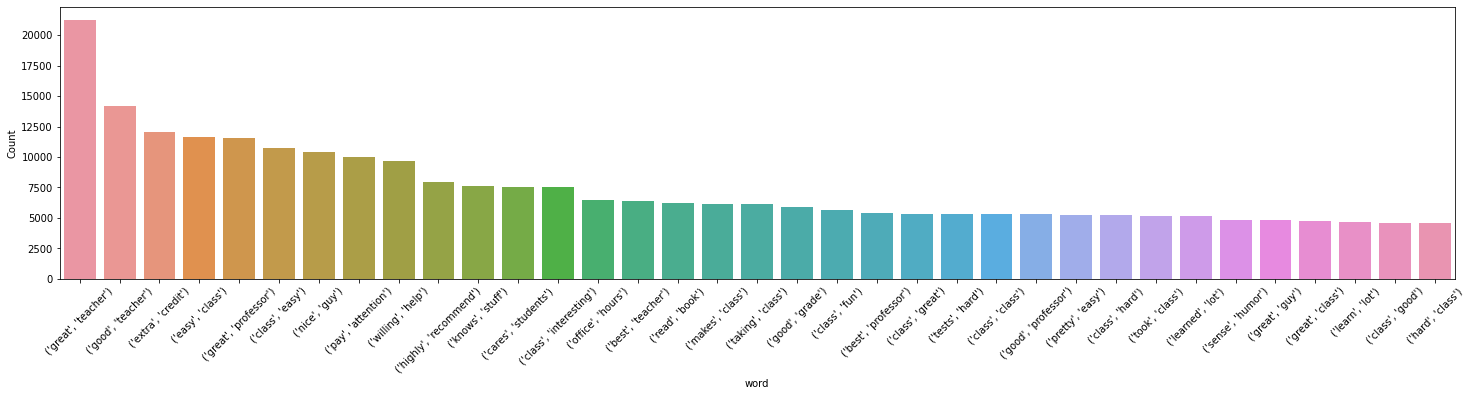

In [22]:
%matplotlib inline
def freq_ngrams(x, terms=30, n=2):        # function to plot most frequent n-grams
    all_words = " ".join([text for text in x])
    all_words = all_words.split()

    ngs = nltk.ngrams(all_words, n)
    fdist = FreqDist(ngs)
    words_df = pd.DataFrame({"word":list(fdist.keys()), "count":list(fdist.values())})

    d = words_df.nlargest(columns="count", n=terms)
    plt.figure(figsize=(25,5))
    plt.xticks(rotation=45)
    ax = sns.barplot(data=d, x="word", y="count")
    ax.set(ylabel="Count")
    plt.show()

freq_ngrams(comments, terms=35, n=2)         # plot most frequent bigrams (2 word pairs)

Plot most common trigrams

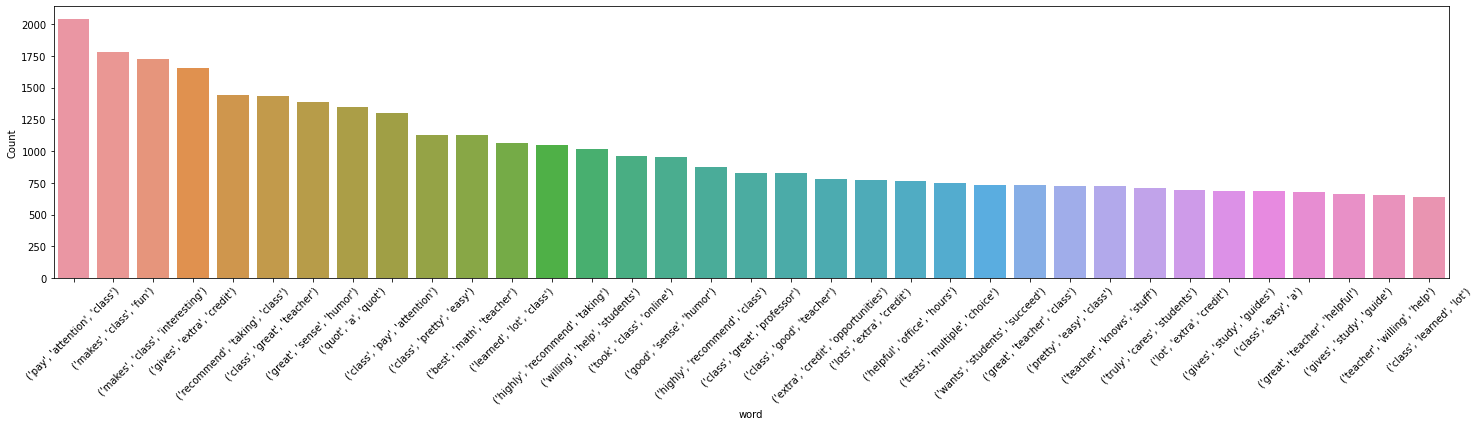

In [23]:
freq_ngrams(comments, terms=35, n=3)         # plot most frequent trigrams (3 word pairs)

Plot most common 4-grams ("quadgrams"??)

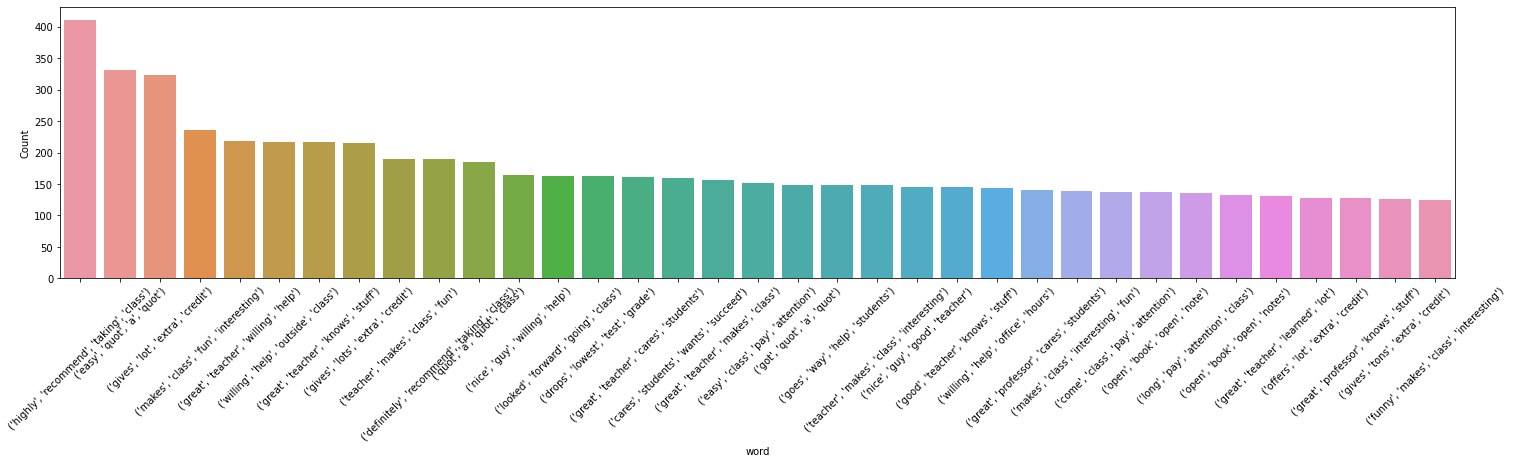

In [24]:
freq_ngrams(comments, terms=35, n=4)         # plot most frequent 4-grams

# Determine how many unique professors there are in sample

Notice how length of unique and length of value_counts are the same (as they always should be lol)

In [32]:
print(len(pd.unique(reviews["lastName"])))
print()

print(reviews["lastName"].value_counts())

60325

Smith         2625
Johnson       1913
Brown         1572
Miller        1539
Williams      1362
              ... 
Ashoke           1
Raevens          1
Basuray          1
Gnilka           1
Tilot-Nigl       1
Name: lastName, Length: 60325, dtype: int64
